In [3]:
import os, glob, re, sys
import socket
import torch
import wandb
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb
import pandas as pd
import umap
from sklearn.manifold import TSNE
from tqdm import tqdm_notebook

sys.path.append('../')
from src.vae_models import *
from src.datasets import Astro_lightcurves
from src.utils import *

import warnings
warnings.filterwarnings('ignore')

main_path = os.path.dirname(os.getcwd())

save_plots = False
save_tables = False

In [4]:
ID = 'yp4qdw1r'
gpu = False

rnd_seed = 13
np.random.seed(rnd_seed)
torch.manual_seed(rnd_seed)
torch.cuda.manual_seed_all(rnd_seed)

In [5]:
if not os.path.exists('%s/wandb/run--%s/VAE_model_None.pt' % 
                      (main_path, ID)):
    print('Downloading files from Weight & Biases')
    
    api = wandb.Api()
    run = api.run('jorgemarpa/Phy-VAE/%s' % (ID))
    run.file('VAE_model_None.pt').download(replace=True, 
                                           root='%s/wandb/run--%s/' % 
                                           (main_path, ID))
    run.file('config.yaml').download(replace=True, 
                                     root='%s/wandb/run--%s/' % 
                                     (main_path, ID))

device = torch.device("cuda:0" if torch.cuda.is_available() and gpu else "cpu")

## Load model variables into VAE model

In [6]:
vae, config = load_model_list(ID=ID)
config

Loading from... 
 /Users/jorgetil/Astro/PELS-VAE/wandb/run--yp4qdw1r/VAE_model_None.pt
Is model in cuda?  False


{'architecture': 'tcn',
 'batch_size': 128,
 'beta_vae': '0.75',
 'classes': 'all',
 'data': 'OGLE3',
 'dropout': 0.2,
 'epochs': 150,
 'feed_pp': 'F',
 'hidden_size': 48,
 'kernel_size': 5,
 'label_dim': 8,
 'latent_dim': 4,
 'latent_mode': 'repeat',
 'learning_rate': 0.001,
 'learning_rate_scheduler': 'cos',
 'n_feats': 3,
 'n_train_params': 300945,
 'num_layers': 9,
 'phys_params': 'PTA',
 'physics_dim': 3,
 'sequence_lenght': 600,
 'transpose': False,
 'normed': True,
 'folded': True,
 'date': '',
 'ID': 'yp4qdw1r'}

In [7]:
dataset = Astro_lightcurves(survey=config['data'],
                            band='I' if config['data'] else 'B',
                            use_time=True,
                            use_err=True,
                            norm=config['normed'],
                            folded=config['folded'],
                            machine=socket.gethostname(),
                            seq_len=config['sequence_lenght'],
                            phy_params=config['phys_params'])

if config['classes'].split('_')[0] == 'drop':
    dataset.drop_class(config['classes'].split('_')[1])
elif config['classes'].split('_')[0] == 'only':
    dataset.only_class(config['classes'].split('_')[1])
print('Using physical parameters: ', dataset.phy_names)
dataset.remove_nan()
print(dataset.class_value_counts())
print('Total: ', len(dataset))
num_cls = dataset.labels_onehot.shape[1]

train_load, test_load = dataset.get_dataloader(batch_size=config['batch_size'],
                                               shuffle=True,
                                               test_split=.2,
                                               random_seed=rnd_seed)

Loading from:
 /Users/jorgetil/Google Drive/Colab_Notebooks/data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600.npy.gz
Using physical parameters:  ['Period', 'teff_val', 'abs_Gmag']
ECL      8817
ELL      8637
LPV      8201
CEP      6906
T2CEP    3734
DSCT     3704
RRLYR    2962
ACEP       70
Name: Type, dtype: int64
None
Total:  43031


In [8]:
mu, std = evaluate_encoder(vae, test_load, config, 
                           n_classes=num_cls, force=True)

Evaluating Encoder...



Elapsed time  : 181.00 s
########################################


In [9]:
test_meta = dataset.meta.iloc[test_load.sampler.indices]
test_lcs = dataset.lcs[test_load.sampler.indices]
mu.shape, std.shape, test_meta.shape, test_lcs.shape

((8606, 5), (8606, 5), (8606, 30), (8606, 600, 3))

# Plot LC reconstruction

# Joint distributions of latent variables

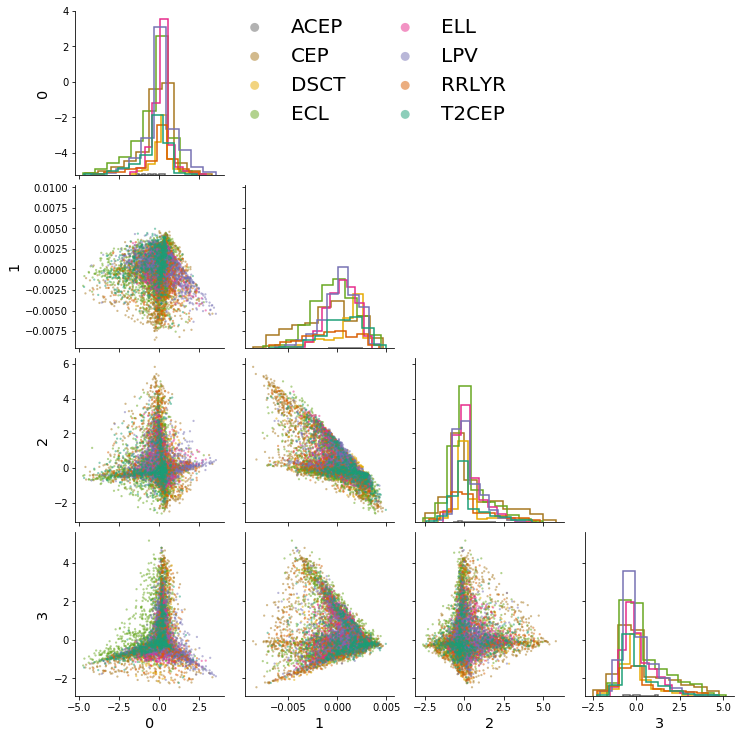

In [10]:
g = sb.PairGrid(mu, 
                hue='class', hue_order=sorted(set(mu.loc[:,'class'].values)),
               corner=False, despine=True, palette='Dark2_r')
g = g.map_diag(plt.hist, histtype='step', lw=1.5)
g = g.map_offdiag(plt.scatter, marker='.', s=20, alpha=.5, edgecolors='none')
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
g = g.add_legend(loc='upper center', fontsize=20, title='', 
                 markerscale=4, ncol=2)    
for ax in g.axes.flat:
    # This only works for the left ylabels
    ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')
    ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')

if save_plots:
    plt.savefig('%s/imgs/z_pairplot_%s.pdf' % (path,ID), 
            format='pdf', bbox_inches='tight')
    
plt.show()

### tSNE projection to 2D

In [11]:
mu_to_tsne = mu.copy()
meta_to_tsne = test_meta.copy()
print(meta_to_tsne.Type.value_counts())

#for perplex in [2,5,8,10,15,20,25,30,40,50,100]:
tsne = TSNE(n_components=2, perplexity=40, 
            random_state=10, verbose=0)
mu_embed = tsne.fit_transform(mu_to_tsne.iloc[:,:-1].values)
print('Embeding shape: ', mu_embed.shape)

ECL      1766
ELL      1734
LPV      1624
CEP      1361
DSCT      763
T2CEP     755
RRLYR     590
ACEP       13
Name: Type, dtype: int64
Embeding shape:  (8606, 2)


In [12]:
meta_to_tsne.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8606 entries, 36682 to 40726
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   OGLE_id                  8606 non-null   object 
 1   RA                       8606 non-null   float32
 2   Dec                      8606 non-null   float32
 3   Type                     8606 non-null   object 
 4   subType                  8606 non-null   object 
 5   GAIA_source_id           8606 non-null   int64  
 6   parallax                 8606 non-null   float32
 7   abs_Gmag                 8606 non-null   float32
 8   phot_g_mean_mag          8606 non-null   float32
 9   phot_bp_mean_mag         8606 non-null   float32
 10  phot_rp_mean_mag         8606 non-null   float32
 11  bp_rp                    8606 non-null   float32
 12  teff_val                 8606 non-null   float32
 13  radius_val               702 non-null    float32
 14  lum_val            

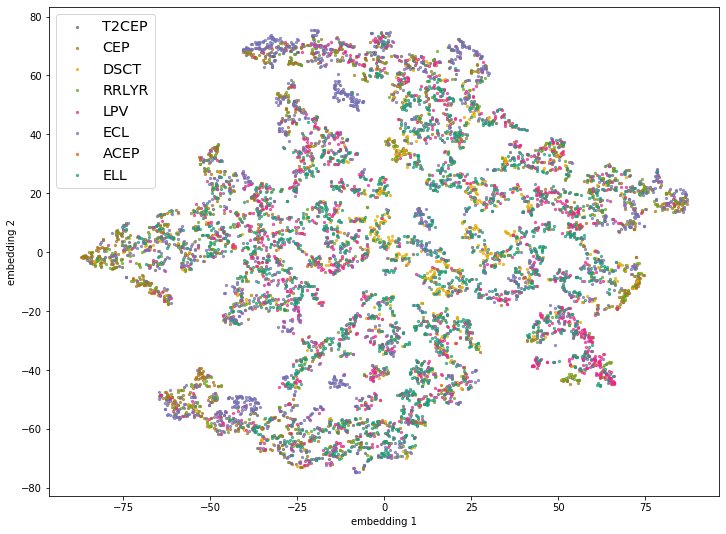

No handles with labels found to put in legend.


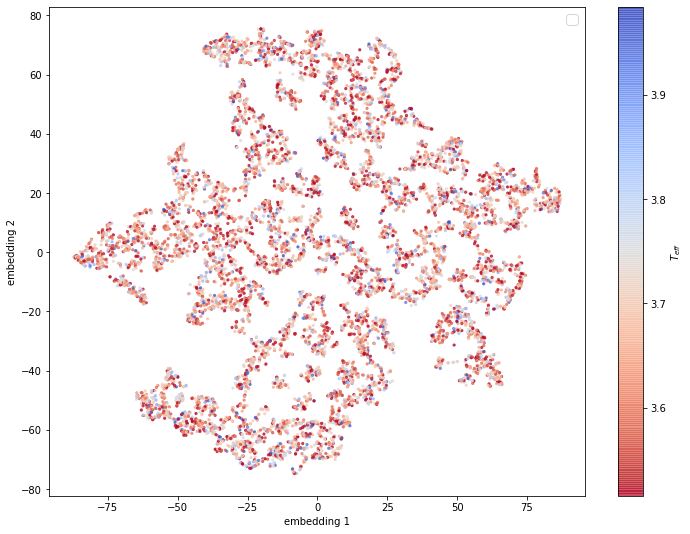

No handles with labels found to put in legend.


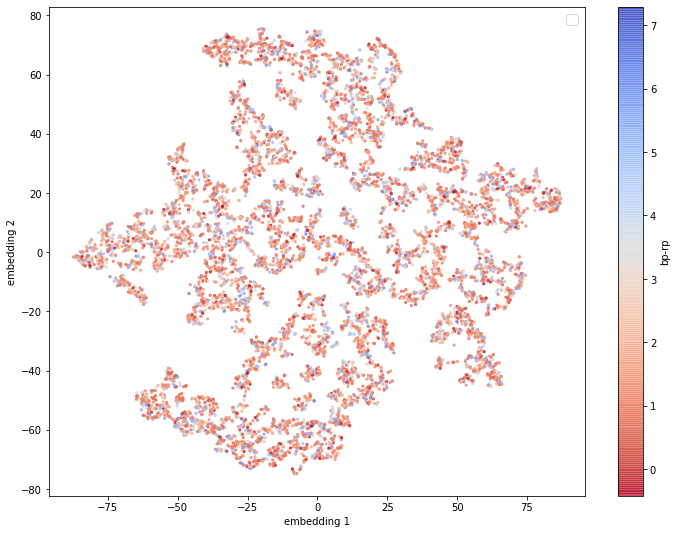

No handles with labels found to put in legend.


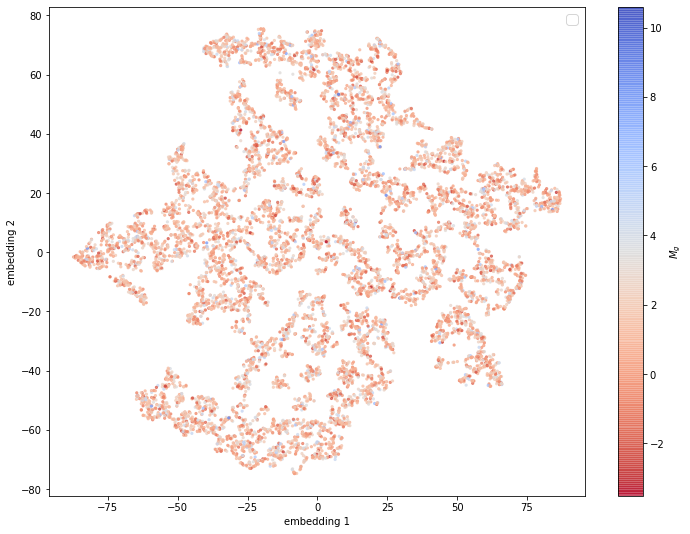

No handles with labels found to put in legend.


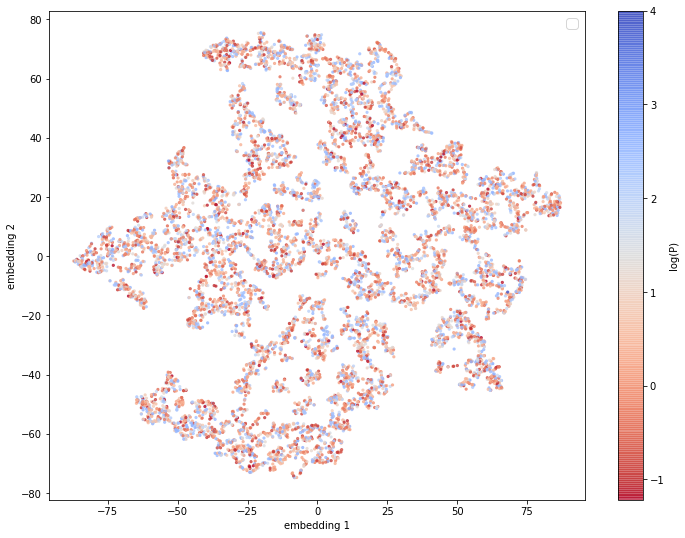

No handles with labels found to put in legend.


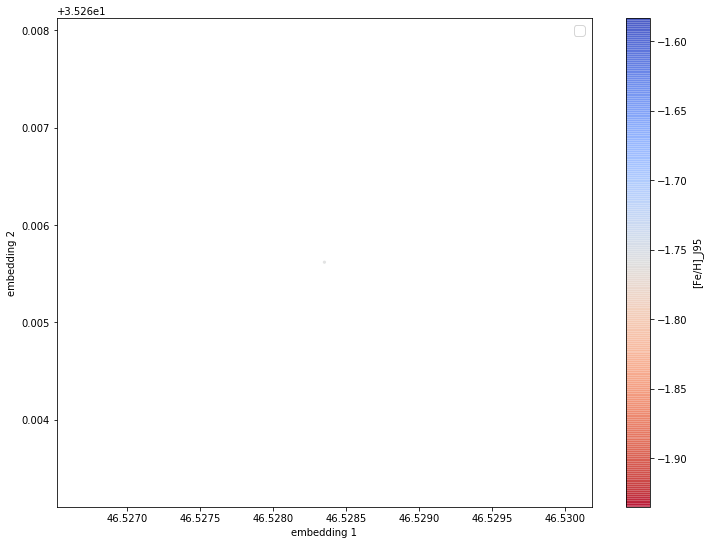

In [13]:
scatter_hue(mu_embed[:,0], mu_embed[:,1], 
            mu_to_tsne.loc[:,'class'].values,
            disc=True)
scatter_hue(mu_embed[:,0], mu_embed[:,1], 
            np.log10(meta_to_tsne.loc[:,'teff_val'].values),
            disc=False, c_label=r'$T_{eff}$')
scatter_hue(mu_embed[:,0], mu_embed[:,1], 
            meta_to_tsne.loc[:,'bp_rp'].values,
            disc=False, c_label='bp-rp')
scatter_hue(mu_embed[:,0], mu_embed[:,1], 
            meta_to_tsne.loc[:,'abs_Gmag'].values,
            disc=False, c_label=r'$M_g$')
scatter_hue(mu_embed[:,0], mu_embed[:,1], 
            np.log10(meta_to_tsne.loc[:,'Period'].values),
            disc=False, c_label='log(P)')
scatter_hue(mu_embed[:,0], mu_embed[:,1], 
            meta_to_tsne.loc[:,'[Fe/H]_J95'].values,
            disc=False, c_label='[Fe/H]_J95')

## UMAP projection

In [14]:
umapper = umap.UMAP(n_neighbors=100, min_dist=0.05, 
                    n_components=2, metric='euclidean')
embedding = umapper.fit_transform(mu_to_tsne.iloc[:,:-1].values)

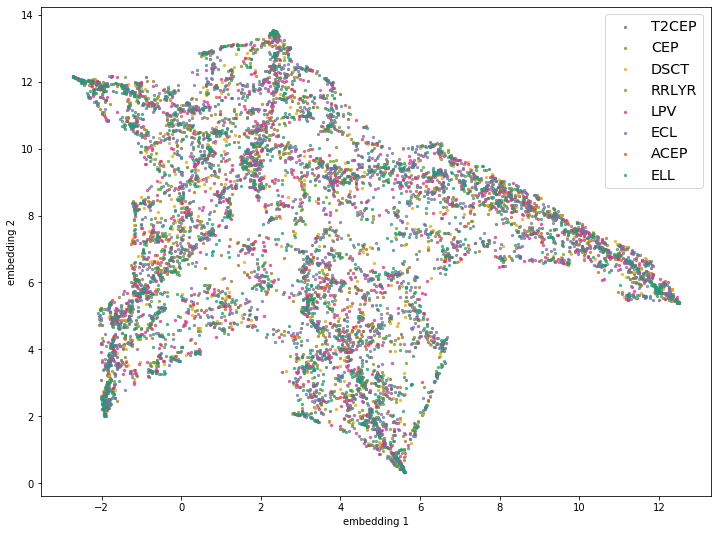

No handles with labels found to put in legend.


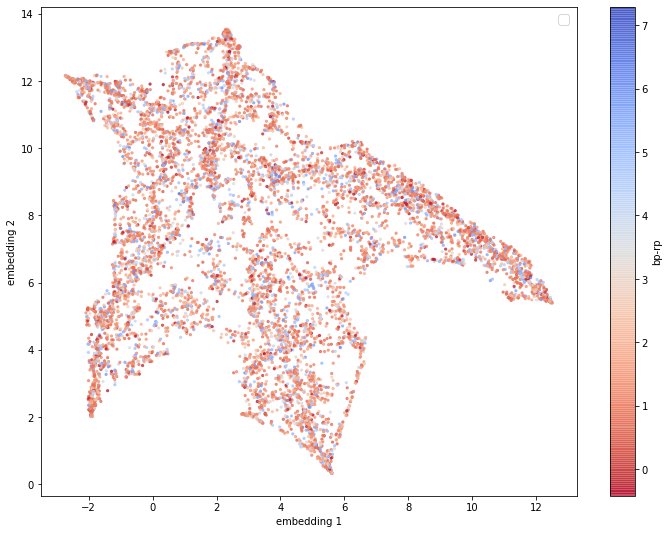

No handles with labels found to put in legend.


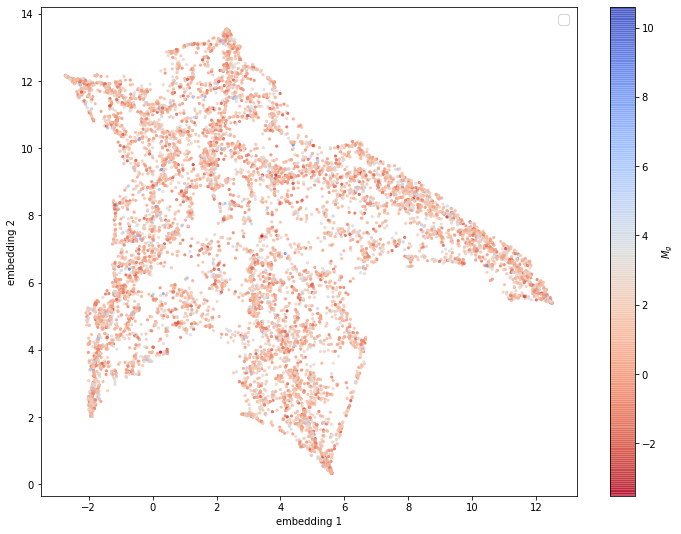

No handles with labels found to put in legend.


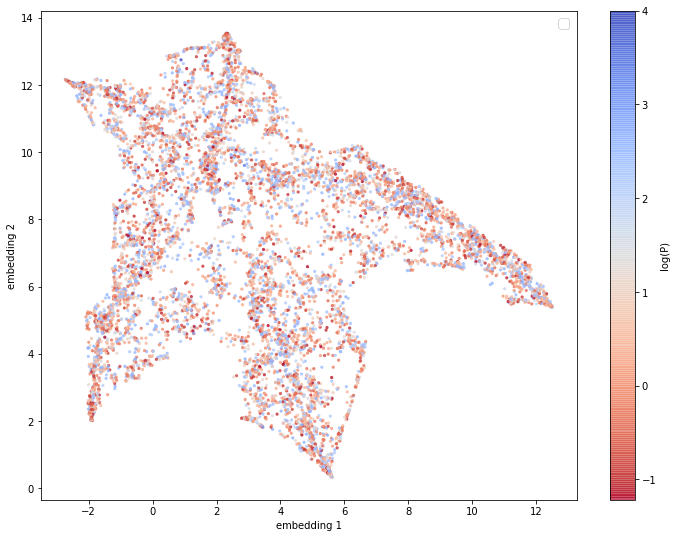

No handles with labels found to put in legend.


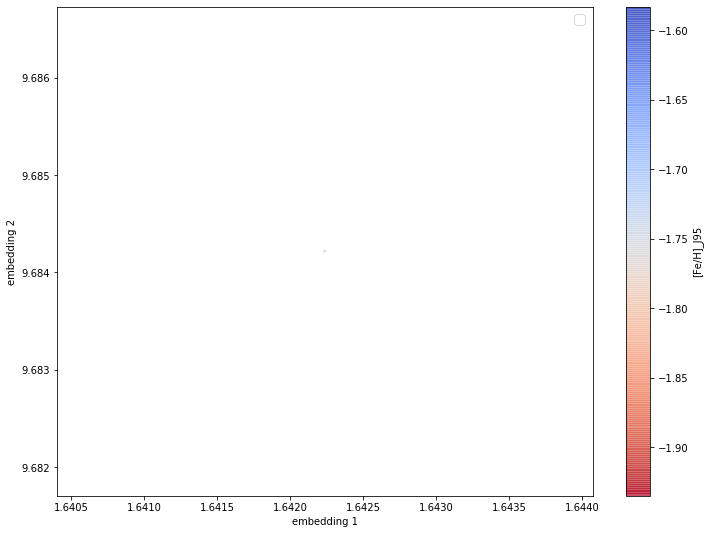

In [15]:
scatter_hue(embedding[:,0], embedding[:,1], 
            meta_to_tsne.loc[:,'Type'].values,
            disc=True)
scatter_hue(embedding[:,0], embedding[:,1], 
            meta_to_tsne.loc[:,'bp_rp'].values,
            disc=False, c_label='bp-rp')
scatter_hue(embedding[:,0], embedding[:,1], 
            meta_to_tsne.loc[:,'abs_Gmag'].values,
            disc=False, c_label=r'$M_g$')
scatter_hue(embedding[:,0], embedding[:,1], 
            np.log10(meta_to_tsne.loc[:,'Period'].values),
            disc=False, c_label='log(P)')
scatter_hue(embedding[:,0], embedding[:,1], 
            meta_to_tsne.loc[:,'[Fe/H]_J95'].values,
            disc=False, c_label='[Fe/H]_J95')

# Evaluate VAE with dT

In [19]:
N_resamp = 5
new_onehot = torch.from_numpy(dataset[test_load.sampler.indices][-2])
new_lcs_t = torch.from_numpy(test_lcs)
new_latent = []

for k in range(N_resamp):
    new_meta = test_meta.copy()
    new_meta.teff_val = np.random.normal(loc=test_meta.teff_val, 
                                         scale=test_meta.teff_e)
    new_meta_pp = torch.from_numpy(dataset.mm_scaler.transform(new_meta.loc[:, dataset.phy_aux].values.astype(np.float32)))
    print(new_lcs_t.shape, new_meta_pp.shape, new_onehot.shape)
    
    if config['label_dim'] > 0 and config['physics_dim'] > 0:
        mu_, logvar_ = vae.encoder(new_lcs_t[:1000], label=new_onehot[:1000], phy=new_meta_pp[:1000])
    elif config['label_dim'] > 0 and config['physics_dim'] == 0:
        mu_, logvar_ = vae.encoder(new_lcs_t, label=new_onehot)
    elif config['label_dim'] == 0:
        mu_, logvar_ = vae.encoder(new_lcs_t)
    new_mu = mu_.detach().numpy()
    new_std = np.exp(0.5 * np.array(logvar_.detach().numpy()))
    new_latent.append([new_mu, new_std])
    
    break

torch.Size([8606, 600, 3]) torch.Size([8606, 3]) torch.Size([8606, 8])


In [23]:
new_latent[0][0].shape

(1000, 4)